# Shape detection

In the last chapter we saw how to remove noise from an image with some filtering but there is another way.

If, instead of looking for all the noise to delete, we could grab what we need and remove everything that is outside of it.

First, try to select the text area on this plan:

<img src="./assets/text_plan.jpg" height="600" />

and draw a line around it like follows:

<img src="./assets/plan_txt_selected.jpg" height="600" />

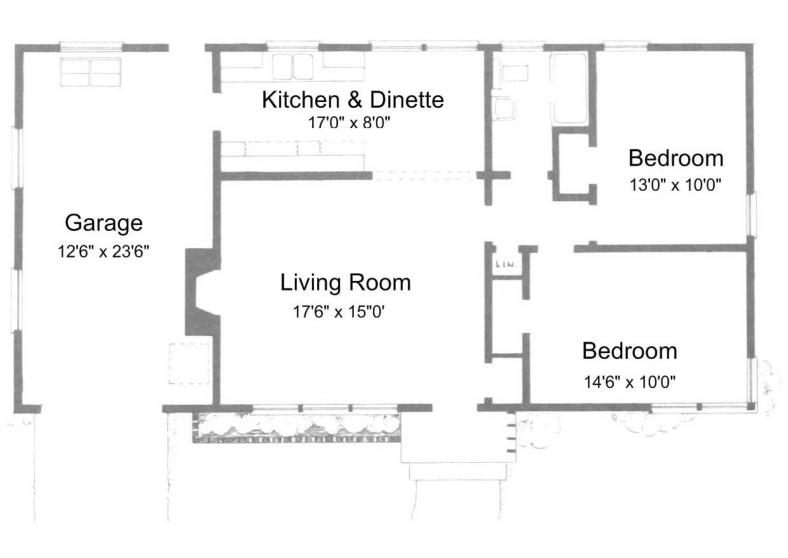

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Change display image size in notebook with matplotlib
# ( https://www.mikulskibartosz.name/how-to-change-plot-size-in-jupyter-notebook/ ) 
plt.rcParams["figure.figsize"] = (20,10)

# Open the image with openCV
img = cv2.imread('assets/text_plan.jpg',cv2.IMREAD_GRAYSCALE)

# Display the image with openCV in notbook
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [3]:

# Select the text

# removes pixels in image that are between the range of
# [lower_val,upper_val]
def remove_gray(img,lower_val,upper_val):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([0,0,lower_val])
    upper_bound = np.array([255,255,upper_val])
    mask = cv2.inRange(gray, lower_bound, upper_bound)
    return cv2.bitwise_and(gray, gray, mask = mask)



# Draw a line around it
# erodes image based on given kernel size (erosion = expands black areas)
def erode( img, kern_size = 3 ):
    retval, img = cv2.threshold(img, 254.0, 255.0, cv2.THRESH_BINARY) # threshold to deal with only black and white.
    kern = np.ones((kern_size,kern_size),np.uint8) # make a kernel for erosion based on given kernel size.
    eroded = cv2.erode(img, kern, 1) # erode your image to blobbify black areas
    y,x = eroded.shape # get shape of image to make a white boarder around image of 1px, to avoid problems with find contours.
    return cv2.rectangle(eroded, (0,0), (x,y), (255,255,255), 1)

# finds contours of eroded image
def prep( img, kern_size = 3 ):    
    img = erode( img, kern_size )
    retval, img = cv2.threshold(img, 200.0, 255.0, cv2.THRESH_BINARY_INV) #   invert colors for findContours
    return cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) # Find Contours of Image

# given img & number of desired blobs, returns contours of blobs.
def blobbify(img, num_of_labels, kern_size = 3, dilation_rate = 10):
    prep_img, contours, hierarchy = prep( img.copy(), kern_size ) # dilate img and check current contour count.
    while len(contours) > num_of_labels:
        kern_size += dilation_rate # add dilation_rate to kern_size to increase the blob. Remember kern_size must always be odd.
        previous = (prep_img, contours, hierarchy)
        processed_img, contours, hierarchy = prep( img.copy(), kern_size ) # dilate img and check current contour count, again.
    if len(contours) < num_of_labels:
        return (processed_img, contours, hierarchy)
    else:
        return previous

# finds bounding boxes of all contours
def bounding_box(contours):
    bBox = []
    for curve in contours:
        box = cv2.boundingRect(curve)
    bBox.append(box)
    return bBox


In [5]:
img = erode(img)
cv2.imshow("erode",img)


TypeError: Expected Ptr<cv::UMat> for argument 'mat'

# solution 2

In [ ]:
import cv2
# Load image, grayscale, Gaussian blur, adaptive threshold
image = cv2.imread('assets/text_plan.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

# Dilate to combine adjacent text contours
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours, highlight text areas, and extract ROIs
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

ROI_number = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > 10000:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)
        # ROI = image[y:y+h, x:x+w]
        # cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
        # ROI_number += 1

# cv2.imshow('thresh', thresh)
# # cv2.imshow('dilate', dilate)
# # cv2.imshow('image', image)
# cv2.waitKey()

## EAST MODEL

# also checkout: https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

In [21]:
#Loading packages 
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

from matplotlib import pyplot as plt

#Creating argument dictionary for the default arguments needed in the code. 
args = {"image":'assets/text_plan.jpg', "east":"./assets/frozen_east_text_detection.pb", "min_confidence":0.5, "width":320, "height":320}

In [22]:
#Give location of the image to be read.

args['image']='assets/text_plan.jpg'
image = cv2.imread(args['image'])

#Saving a original image and shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (args["width"], args["height"])

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [23]:
# load the pre-trained EAST model for text detection 
net = cv2.dnn.readNet(args["east"])

# The following two layer need to pulled from EAST model for achieving this. 
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
  
#Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < args["min_confidence"]:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)

In [24]:
# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

##Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
	r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
	configuration = ("-l eng --oem 1 --psm 8")
    ##This will recognize the text from the image of bounding box
	text = pytesseract.image_to_string(r, config=configuration)

	# append bbox coordinate and associated text to the list of results 
	results.append(((startX, startY, endX, endY), text))

Redroor


Living


Garaage


200m


Bedroom


Kitchen


COCR Corer


x 23'6"


4310" x.


Dinette


40'0"


49'6" y


476" x4


6 10'0".


14'6" x


— 47'0"


x Bio" |




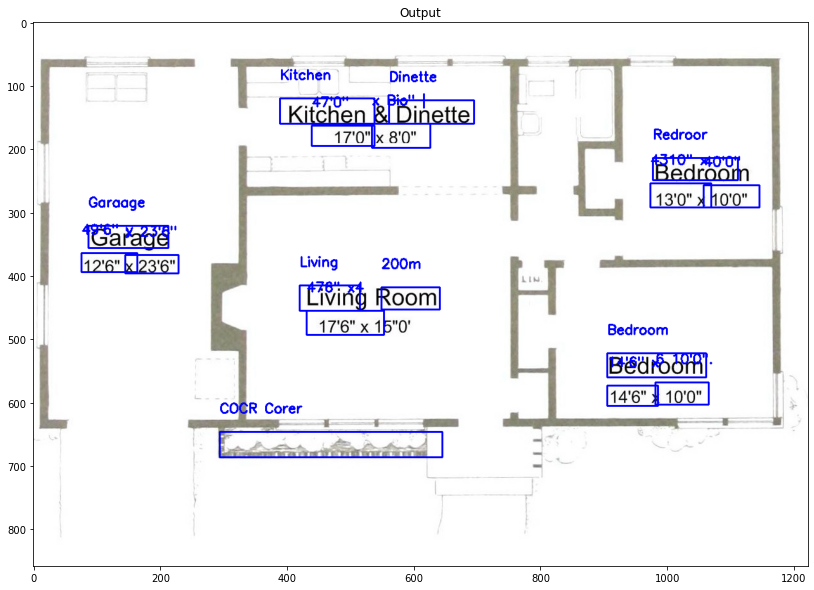

In [25]:
#Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()

Now delete everything outside of those boxes (fill it with white pixels)

In [ ]:
# Remove everything except the text



Now invert to colors so the white become black and the black become white

In [ ]:
# Code here



Congratulations! You are now a pro in image preprocessing with opencv.

Just joking, opencv is an endless library, there are even machine learning models in it!
Now that you have the basics down, you know where to search next time you will need to preprocess an image!

![pro photohop](https://media.giphy.com/media/t1HJXy5Q5NKA8/giphy.gif)

[Images source](https://stackoverflow.com/questions/37771263/detect-text-area-in-an-image-using-python-and-opencv)